# Hospital Readmission Classification Task

Dataset: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [2]:
dat = pd.read_csv("./dataset_diabetes/diabetic_data.csv")
dat.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Data Preprocessing

#### Replacing ">30" days readmission with "NO" for simplicity

In [3]:
dat['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [4]:
dat['readmitted'].replace(to_replace =">30",value ="NO", inplace=True)
dat['readmitted'].value_counts()

NO     90409
<30    11357
Name: readmitted, dtype: int64

Change type of these fields as category for model later.

In [5]:
dat['admission_type_id']=dat['admission_type_id'].astype('category')
dat['discharge_disposition_id']=dat['discharge_disposition_id'].astype('category')
dat['admission_source_id']=dat['admission_source_id'].astype('category')
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   encounter_id              101766 non-null  int64   
 1   patient_nbr               101766 non-null  int64   
 2   race                      101766 non-null  object  
 3   gender                    101766 non-null  object  
 4   age                       101766 non-null  object  
 5   weight                    101766 non-null  object  
 6   admission_type_id         101766 non-null  category
 7   discharge_disposition_id  101766 non-null  category
 8   admission_source_id       101766 non-null  category
 9   time_in_hospital          101766 non-null  int64   
 10  payer_code                101766 non-null  object  
 11  medical_specialty         101766 non-null  object  
 12  num_lab_procedures        101766 non-null  int64   
 13  num_procedures            101

#### Handling categorical variables with a large number of categories
Filtering them down to only count the top most frequent, since many categories don't occur very often.

In [6]:
def inArray(arr, test):
    
    toReturn=np.array([], dtype=bool)
    
    for elem in arr:
        if elem in test:
            toReturn = np.append(toReturn, True)
        else:
            toReturn = np.append(toReturn, False)
    
    return pd.Series(toReturn)

In [7]:
topCat = dat['medical_specialty'].value_counts().head(10).index.to_numpy()
dat.loc[~inArray(dat['medical_specialty'], topCat), 'medical_specialty'] = "Other"
dat['medical_specialty'].replace(to_replace="?", value="Other", inplace=True)

topCat = dat['diag_1'].value_counts().head(5).index.to_numpy()
dat.loc[~inArray(dat['diag_1'], topCat), 'diag_1'] = "Other"
dat['diag_1'].replace(to_replace="?", value="Other", inplace=True)

topCat = dat['diag_2'].value_counts().head(5).index.to_numpy()
dat.loc[~inArray(dat['diag_2'], topCat), 'diag_2'] = "Other"
dat['diag_2'].replace(to_replace="?", value="Other", inplace=True)

topCat = dat['diag_3'].value_counts().head(5).index.to_numpy()
dat.loc[~inArray(dat['diag_3'], topCat), 'diag_3'] = "Other"
dat['diag_3'].replace(to_replace="?", value="Other", inplace=True)

In [8]:
datClean = dat.drop(['encounter_id', 'patient_nbr'], axis=1)

#### One-Hot Encoding Data

In [9]:
datClean = pd.get_dummies(datClean,drop_first=True)

Optional code below. Was playing around to see if any feature selection combinations impacted results.

In [10]:
# datClean = datClean[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
#        'num_medications', 'number_outpatient', 'number_emergency',
#        'number_inpatient', 'number_diagnoses', 'race_AfricanAmerican',
#        'race_Caucasian', 'gender_Male', 'age_[60-70)', 'age_[70-80)',
#        'age_[80-90)', 'admission_type_id_2', 'admission_type_id_3',
#        'discharge_disposition_id_3', 'discharge_disposition_id_6',
#        'admission_source_id_7', 'payer_code_MC',
#        'medical_specialty_InternalMedicine', 'medical_specialty_Other',
#        'diag_1_Other', 'diag_2_Other', 'diag_3_Other', 'insulin_Steady',
#        'change_No', 'readmitted_NO']]

In [11]:
datClean.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes,readmitted_NO
0,1,41,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
1,3,59,0,18,0,0,0,9,0,0,...,1,0,0,0,0,0,0,0,1,1
2,2,11,5,13,2,0,1,6,1,0,...,1,0,0,0,0,0,0,1,1,1
3,2,44,1,16,0,0,0,7,0,0,...,1,0,0,0,0,0,0,0,1,1
4,1,51,0,8,0,0,0,5,0,0,...,1,0,0,0,0,0,0,0,1,1


#### Custom functions for oversampling, undersampling, and SMOTE for imbalanced data handling

In [12]:
def oversample(x, y):
    
    comb = pd.concat([x, y], axis=1)
    
    readmit = comb[comb['readmitted_NO']==0]
    notReadmit = comb[comb['readmitted_NO']==1]
    
    upsample = resample(readmit,
                       replace = True,
                       n_samples = len(notReadmit),
                       random_state = 53)
    
    upsample = pd.concat([notReadmit, upsample])
    X = upsample.drop('readmitted_NO',axis=1)
    Y = upsample['readmitted_NO']
    return(X,Y)

def downsample(x, y):
    
    comb = pd.concat([x, y], axis=1)
    
    readmit = comb[comb['readmitted_NO']==0]
    notReadmit = comb[comb['readmitted_NO']==1]
    
    downsample = resample(notReadmit,
                       replace = False,
                       n_samples = len(readmit),
                       random_state = 53)
    
    downsample = pd.concat([downsample, readmit])
    X = downsample.drop('readmitted_NO',axis=1)
    Y = downsample['readmitted_NO']
    return(X,Y)

def customSMOTE(x, y):
    
    sm = SMOTE(random_state = 53)
    X, Y = sm.fit_resample(x, y)
    return(X, Y)


#### Separate into training and validation sets

In [13]:
X = datClean.drop('readmitted_NO',axis=1)
Y = datClean['readmitted_NO']
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(X, Y, test_size=0.30, random_state=53)

In [14]:
Ytrain.value_counts()

1    63329
0     7907
Name: readmitted_NO, dtype: int64

Accuracy from guessing not re_admitted:

In [15]:
63329 / (63329+7907)

0.8890027514178225

### RandomForest

#### RandomForest with Oversampling 

In [16]:
XtrainOver, YtrainOver = oversample(Xtrain, Ytrain)

rfover = RandomForestClassifier(n_estimators=600)
rfover.fit(XtrainOver,YtrainOver)

predictions = rfover.predict(Xvalid)
print(classification_report(Yvalid,predictions))
print(confusion_matrix(Yvalid, predictions))
print(roc_auc_score(Yvalid, rfover.predict_proba(Xvalid)[:,1]))

              precision    recall  f1-score   support

           0       0.51      0.02      0.04      3450
           1       0.89      1.00      0.94     27080

    accuracy                           0.89     30530
   macro avg       0.70      0.51      0.49     30530
weighted avg       0.85      0.89      0.84     30530

[[   79  3371]
 [   76 27004]]
0.6593247704065249


#### RandomForest with Undersampling

In [17]:
XtrainUnder, YtrainUnder = downsample(Xtrain, Ytrain)

rfunder = RandomForestClassifier(n_estimators=600)
rfunder.fit(XtrainUnder,YtrainUnder)

predictions = rfunder.predict(Xvalid)
print(classification_report(Yvalid,predictions))
print(confusion_matrix(Yvalid, predictions))
print(roc_auc_score(Yvalid, rfunder.predict_proba(Xvalid)[:,1]))

              precision    recall  f1-score   support

           0       0.17      0.62      0.27      3450
           1       0.93      0.62      0.74     27080

    accuracy                           0.62     30530
   macro avg       0.55      0.62      0.51     30530
weighted avg       0.84      0.62      0.69     30530

[[ 2123  1327]
 [10259 16821]]
0.6644839980305268


#### RandomForest with SMOTE

In [18]:
XtrainSM, YtrainSM = customSMOTE(Xtrain, Ytrain)

rfSM = RandomForestClassifier(n_estimators=600)
rfSM.fit(XtrainSM,YtrainSM)

predictions = rfSM.predict(Xvalid)
print(classification_report(Yvalid,predictions))
print(confusion_matrix(Yvalid, predictions))
print(roc_auc_score(Yvalid, rfSM.predict_proba(Xvalid)[:,1]))

              precision    recall  f1-score   support

           0       0.29      0.02      0.03      3450
           1       0.89      0.99      0.94     27080

    accuracy                           0.88     30530
   macro avg       0.59      0.51      0.48     30530
weighted avg       0.82      0.88      0.84     30530

[[   55  3395]
 [  137 26943]]
0.600203449789138


In [19]:
rf = RandomForestClassifier(n_estimators=600)
rf.fit(Xtrain,Ytrain)

predictions = rf.predict(Xvalid)
print(classification_report(Yvalid,predictions))
print(confusion_matrix(Yvalid, predictions))
print(roc_auc_score(Yvalid, rf.predict_proba(Xvalid)[:,1]))

              precision    recall  f1-score   support

           0       0.60      0.01      0.02      3450
           1       0.89      1.00      0.94     27080

    accuracy                           0.89     30530
   macro avg       0.75      0.50      0.48     30530
weighted avg       0.86      0.89      0.84     30530

[[   29  3421]
 [   19 27061]]
0.6545955033930597


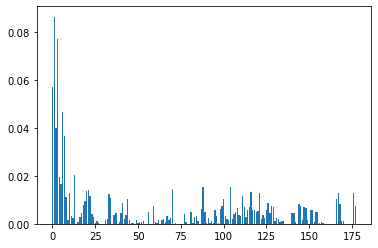

In [20]:
importance = rf.feature_importances_
# summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [21]:
Xtrain.columns[importance > .01]

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'race_AfricanAmerican',
       'race_Caucasian', 'gender_Male', 'age_[60-70)', 'age_[70-80)',
       'age_[80-90)', 'admission_type_id_2', 'admission_type_id_3',
       'discharge_disposition_id_6', 'admission_source_id_7', 'payer_code_MC',
       'medical_specialty_InternalMedicine', 'medical_specialty_Other',
       'diag_1_Other', 'diag_2_Other', 'diag_3_Other', 'insulin_No',
       'insulin_Steady', 'change_No'],
      dtype='object')

In [22]:
XtrainOver.shape[1]

178

In [23]:
rf = RandomForestClassifier(n_estimators=600)#, class_weight = "balanced"

rfparams = {"max_features": range(5, 30, 5),
            "max_depth": [10, 15, 20]}

rfCV = GridSearchCV(rf, rfparams, n_jobs=-1, cv=2, scoring = 'roc_auc', verbose=2).fit(XtrainOver, YtrainOver)
print(rfCV.best_score_)
print(rfCV.best_params_)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
0.9511646329667732
{'max_depth': 20, 'max_features': 25}


In [24]:
#rf = RandomForestClassifier(max_features='sqrt', max_depth=20)
#rf.fit(XtrainOver,YtrainOver)

rf = rfCV.best_estimator_
#predicted_prob = rf_model.predict_proba(Xvalid)[:, 1]
#predicted = rf_model.predict(x_test_rf)
#AUC_RF = roc_auc_score(y_test_rf, predicted_prob)

predictions = rf.predict(Xvalid)
print(classification_report(Yvalid,predictions))
print(confusion_matrix(Yvalid, predictions))
print(roc_auc_score(Yvalid, rf.predict_proba(Xvalid)[:,1]))

              precision    recall  f1-score   support

           0       0.22      0.29      0.25      3450
           1       0.91      0.87      0.89     27080

    accuracy                           0.81     30530
   macro avg       0.57      0.58      0.57     30530
weighted avg       0.83      0.81      0.82     30530

[[  985  2465]
 [ 3404 23676]]
0.6552397726542932


### Logistic Regression

Cell below commented out. Feature selection model.

In [25]:
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression

# logreg = LogisticRegression(max_iter=5000)
# rfe = RFE(logreg, 20)
# rfe = rfe.fit(XtrainOver, YtrainOver.values.ravel())
# print(rfe.support_)
# print(rfe.ranking_)

# XtrainOver = XtrainOver[XtrainOver.columns[rfe.support_]]
# XtrainOver.info()

# import statsmodels.api as sm
# logit_model=sm.Logit(YtrainOver, XtrainOver)
# result=logit_model.fit()
# print(result.summary2())

In [26]:
XtrainOver, YtrainOver = oversample(Xtrain, Ytrain)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(XtrainOver, YtrainOver)

/home/quantumabyss/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [27]:
pred = logreg.predict(Xvalid)
print(classification_report(Yvalid, pred))
print(confusion_matrix(Yvalid, pred))
print(roc_auc_score(Yvalid, pred))

              precision    recall  f1-score   support

           0       0.18      0.57      0.27      3450
           1       0.92      0.67      0.78     27080

    accuracy                           0.66     30530
   macro avg       0.55      0.62      0.53     30530
weighted avg       0.84      0.66      0.72     30530

[[ 1956  1494]
 [ 8889 18191]]
0.6193534455076745


### Neural Network

Scaling not necessary apparently. Cell below is commented out.

In [28]:
# from sklearn.preprocessing import StandardScaler

# X = datClean.drop('readmitted_NO',axis=1)
# Y = datClean['readmitted_NO']

# scaler = StandardScaler()
# standardized = scaler.fit_transform(X)
# # inverse transform
# inverse = scaler.inverse_transform(standardized)
# standardized.shape

In [29]:
Xtrain, Xvalid, Ytrain, Yvalid = train_test_split(X, Y, test_size=0.30, random_state=53)

In [30]:
model = Sequential()
model.add(Dense(256, input_dim=178, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [31]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(Xtrain, Ytrain, epochs=10, batch_size=10)

Epoch 1/10
7124/7124 [==============================] - 11s 631us/step - loss: 0.3601 - accuracy: 0.8872
Epoch 2/10
7124/7124 [==============================] - 4s 626us/step - loss: 0.3351 - accuracy: 0.8897
Epoch 3/10
7124/7124 [==============================] - 4s 627us/step - loss: 0.3364 - accuracy: 0.8875
Epoch 4/10
7124/7124 [==============================] - 4s 628us/step - loss: 0.3271 - accuracy: 0.8907
Epoch 5/10
7124/7124 [==============================] - 4s 626us/step - loss: 0.3322 - accuracy: 0.8893
Epoch 6/10
7124/7124 [==============================] - 4s 627us/step - loss: 0.3328 - accuracy: 0.8882
Epoch 7/10
7124/7124 [==============================] - 4s 627us/step - loss: 0.3310 - accuracy: 0.8892
Epoch 8/10
7124/7124 [==============================] - 4s 626us/step - loss: 0.3328 - accuracy: 0.8879
Epoch 9/10
7124/7124 [==============================] - 4s 626us/step - loss: 0.3308 - accuracy: 0.8884
Epoch 10/10
7124/7124 [==============================] - 4s 626

In [32]:
# evaluate the keras model
_, accuracy = model.evaluate(Xvalid, Yvalid)
print('Accuracy: %.2f' % (accuracy*100))

955/955 [==============================] - 1s 392us/step - loss: 0.3373 - accuracy: 0.8871
Accuracy: 88.71


In [33]:
predictions = model.predict_classes(Xvalid)
#predictions = rfover.predict(Xvalid)
print(classification_report(Yvalid,predictions))
print(confusion_matrix(Yvalid, predictions))
print(roc_auc_score(Yvalid, model.predict(Xvalid)))

/home/quantumabyss/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.52      0.02      0.03      3450
           1       0.89      1.00      0.94     27080

    accuracy                           0.89     30530
   macro avg       0.70      0.51      0.49     30530
weighted avg       0.85      0.89      0.84     30530

[[   57  3393]
 [   53 27027]]
0.6733835709545523
